# Deep Q-Learning Applied to Algorithmic Trading

<a href="https://www.kaggle.com/code/addarm/deep-q-rl-with-algorithmic-trading-policy" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


<a href="https://colab.research.google.com/github/adamd1985/Deep-Q-Learning-Applied-to-Algorithmic-Trading/blob/main/drl_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


!["Pavlov's trader dog, DALEE 2024"](https://github.com/adamd1985/Deep-Q-Learning-Applied-to-Algorithmic-Trading/blob/main/images/rl_banner.PNG?raw=true)

In the book *"A Random Walk Down Wall Street"*, the author Burton G. Malkiel claimed that: “a blindfolded monkey throwing darts at a newspaper's financial pages could select a portfolio that would do just as well as one carefully selected by experts.”.

What if instead of monkey, it was Pavlov's dog trained with reinforcement learning to select the optimal portfolio strategy? In this article, Reinforcement Learning (RL) is the one used in machine learning, where an agent learns actions in an environment that maximizes their value. The agent learns from the outcomes of its actions, without being explicitly programmed with task-specific rules,

The goal of any RL algo, is to find value-maximizing policy (*π*):
$$
\pi* = \sum_{k=0}^{\infty} \gamma^k R_{t+k+1}
$$
Where *γ (0 ≤ γ ≤ 1)* is the discounting factor to control the agent's rewards, *t* is a timestep and *R* is the returns in that step. The policy in RL is the probability of taking **action *a*** in **state *s***.

The algo we will adopt is **Q-Learning**, a model-free RL algorithm, that aims to indirectly learn the policy through the **VALUE** of an action for a discrete state its in, rather the policy itself. It's useful in our case, as it doesn't need to model the environment - in our case, the random capital markets.

Estimating the **Q-Value** is done through the Bellman's equation:

$$
Q^*(s, a) = \mathbb{E}[R_{t+1} + \gamma \max_{a'} Q^*(s', a') \mid s, a]
$$

These Q-values are placed in the Q-Tables and used by the agent as look-up, to find all possible actions' Q-values from the current state, and choose the action with the highest Q-value (exploitation). This is good within a finite space, but not in a stochastic environment with limitless combinations, a problem which we will solve with our neural-network.

This agent designed in this article has been inspired by the paper of *Théate, Thibaut and Ernst, Damien (2021)*.

```BibTeX
@article{theate2021application,
  title={An application of deep reinforcement learning to algorithmic trading},
  author={Th{\'e}ate, Thibaut and Ernst, Damien},
  journal={Expert Systems with Applications},
  volume={173},
  pages={114632},
  year={2021},
  publisher={Elsevier}
}
```

In [1]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1' # KERAS 2 only for tfagents

import warnings
warnings.filterwarnings("ignore")

try:
  import google.colab
  from google.colab import files
  from google.colab import drive

  %pip install scikit-learn
  %pip install matplotlib
  %pip install tf-agents[reverb]
  %pip install shutil
  %pip install yfinance
  %pip install pyarrow
  %pip install ta
  %pip install pandas_ta
  %pip install tqdm

  IN_COLAB = True
  GDRIVE = '/content/drive'
  drive.mount(GDRIVE)
  print("Mounted on COLLAB")
except:
  GDRIVE = None
  IN_COLAB = False
  files = None

In [2]:
if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    print('Running in Kaggle...')

    %pip install scikit-learn
    %pip install matplotlib
    %pip install tf-agents[reverb]
    %pip install shutil
    %pip install yfinance
    %pip install pyarrow
    %pip install ta
    %pip install pandas_ta
    %pip install tqdm

    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

    DATA_DIR = "/kaggle/input/DATASET"
    IN_KAGGLE = True
else:
    IN_KAGGLE = False
    DATA_DIR = "./data/"

Running in Kaggle...
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 12.3 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.4 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.23.0-py3-none-any.whl size=697630 sha256=0400ea1588a331cea2e76ad5b9d69d25d9478a0e1263c2e7a0e5d03a

In [3]:
import numpy as np
import math
import shutil
import yfinance as yf
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import datetime

from scipy.stats import skew, kurtosis
from ta.utils import dropna
from ta.trend import MACD, EMAIndicator
from ta.volatility import AverageTrueRange

import tensorflow as tf
from tf_agents.specs import array_spec, tensor_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.utils import common
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import py_environment, tf_py_environment, utils
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy, policy_saver, random_tf_policy
from tf_agents.train.utils import strategy_utils

import reverb
from tf_agents.replay_buffers import reverb_replay_buffer, reverb_utils

from tqdm import tqdm

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# Sadly couldn't get TFAgents working on TPU or mirrored strat.
strategy = strategy_utils.get_strategy(tpu=False, use_gpu=False)
print("Running on CPU")

os.getcwd()

2024-03-19 02:24:06.256385: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-19 02:24:06.256581: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-19 02:24:06.445278: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Running on CPU


'/kaggle/working'

In [4]:
START_DATE = "2017-01-01"
SPLIT_DATE = '2018-1-1' # Turning point from train to tst
END_DATE = "2019-12-31" # pd.Timestamp(datetime.now() - BDay(1)).strftime('%Y-%m-%d')
DATA_DIR = "./data"
INDEX = "Date"
TARGET = 'TSLA'
RATES_INDEX = "^TNX"  # 10 Year Treasury Note Yield
VOLATILITY_INDEX = "^VIX"  # CBOE Volatility Index
SMALLCAP_INDEX = "^RUT" # Russell 2000 Index
GOLD_INDEX = "GC=F" # Gold futures
MARKET = "^SPX"
TICKER_SYMBOLS = [TARGET, RATES_INDEX, VOLATILITY_INDEX, SMALLCAP_INDEX, GOLD_INDEX, MARKET]
INTERVAL = "1d"

MODELS_PATH = './models'
LOGS_PATH = './logs'

ACT_NEUTRAL = 3 # Added this action to go to neutral and wait
ACT_HOLD = 2
ACT_LONG = 1
ACT_SHORT = 0
ACTIONS = [ACT_SHORT, ACT_LONG]

CAPITAL = 100000
TRADE_COSTS_PERCENT = 10 / 100 / 100 # 10BPS costs

MACRO_FEATURES = [RATES_INDEX, VOLATILITY_INDEX, MARKET]
TA_FEATURES = ['MACD', 'MACD_HIST', 'MACD_SIG', 'ATR']
FEATURES = ["Close", "High", "Low", "Open", "Volume"]
TARGET_FEATURE = "Price Raw"
STATE_LEN = 30
OBS_SPACE = (STATE_LEN)*len(FEATURES)
ACT_SPACE = len(ACTIONS)

BATCH_SIZE = 32 * strategy.num_replicas_in_sync
LEARN_RATE = 1e-3
TOTAL_ITERS = 1000
TRAIN_EPISODES = 10
INIT_COLLECT = 100
TOTAL_COLLECT = 1
LOG_INTERVALS = 400
TEST_INTERVALS = 600
MEMORY_LENGTH = 100000
DISCOUNT = .35 # Short term gains < 5 or long > 5
EPSILON_START = 1.
TARGET_UPDATE = 1000
EPSILON_END = 0.0005
EPSILON_DECAY = 10000
GRAD_CLIP = 1
REWARD_CLIP = 1
PUNISHMENT = 1.5 # Increase the negative 'reward'

DROPOUT = 0.4
L2FACTOR = 0.000001
NEURONS = 512
LAYERS = (NEURONS, NEURONS, NEURONS, NEURONS, NEURONS)

# Financial Data

We download some financial data, this is now the standard in our articles.

In [5]:
def get_tickerdata(tickers_symbols, start=START_DATE, end=END_DATE, interval=INTERVAL, datadir=DATA_DIR):
    tickers = {}
    earliest_end= datetime.strptime(end,'%Y-%m-%d')
    latest_start = datetime.strptime(start,'%Y-%m-%d')
    os.makedirs(DATA_DIR, exist_ok=True)
    for symbol in tickers_symbols:
        cached_file_path = f"{datadir}/{symbol}-{start}-{end}-{interval}.csv"

        try:
            if os.path.exists(cached_file_path):
                df = pd.read_parquet(cached_file_path)
                df.index = pd.to_datetime(df.index)
                assert len(df) > 0
            else:
                df = yf.download(
                    symbol,
                    start=START_DATE,
                    end=END_DATE,
                    progress=False,
                    interval=INTERVAL,
                )
                assert len(df) > 0
                df.to_parquet(cached_file_path, index=True, compression="snappy")
            min_date = df.index.min()
            max_date = df.index.max()
            nan_count = df["Close"].isnull().sum()
            skewness = round(skew(df["Close"].dropna()), 2)
            kurt = round(kurtosis(df["Close"].dropna()), 2)
            outliers_count = (df["Close"] > df["Close"].mean() + (3 * df["Close"].std())).sum()
            print(
                f"{symbol} => min_date: {min_date}, max_date: {max_date}, kurt:{kurt}, skewness:{skewness}, outliers_count:{outliers_count},  nan_count: {nan_count}"
            )
            tickers[symbol] = df

            if min_date > latest_start:
                latest_start = min_date
            if max_date < earliest_end:
                earliest_end = max_date
        except Exception as e:
            print(f"Error with {symbol}: {e}")

    return tickers, latest_start, earliest_end

tickers, latest_start, earliest_end = get_tickerdata(TICKER_SYMBOLS)

from ta.utils import dropna
from ta.trend import MACD, EMAIndicator
from ta.volatility import AverageTrueRange

stock_df = tickers[TARGET].copy()

macd = MACD(close=stock_df["Close"], window_slow=26, window_fast=12, window_sign=9, fillna=True)
stock_df['MACD'] = macd.macd()
stock_df['MACD_HIST'] = macd.macd_diff()
stock_df['MACD_SIG'] = macd.macd_signal()

atr = AverageTrueRange(stock_df["High"], stock_df["Low"], stock_df["Close"], window = 14, fillna = True)
stock_df['ATR'] = atr.average_true_range()

ema = EMAIndicator(stock_df["Close"], window = 14, fillna = True)
stock_df['EMA'] = ema.ema_indicator()

stock_df

TSLA => min_date: 2017-01-03 00:00:00, max_date: 2019-12-30 00:00:00, kurt:-0.56, skewness:-0.28, outliers_count:0,  nan_count: 0
^TNX => min_date: 2017-01-03 00:00:00, max_date: 2019-12-30 00:00:00, kurt:-0.64, skewness:-0.29, outliers_count:0,  nan_count: 0
^VIX => min_date: 2017-01-03 00:00:00, max_date: 2019-12-30 00:00:00, kurt:3.5, skewness:1.55, outliers_count:11,  nan_count: 0
^RUT => min_date: 2017-01-03 00:00:00, max_date: 2019-12-30 00:00:00, kurt:-0.71, skewness:0.05, outliers_count:0,  nan_count: 0
GC=F => min_date: 2017-01-03 00:00:00, max_date: 2019-12-30 00:00:00, kurt:0.24, skewness:1.05, outliers_count:0,  nan_count: 0
^SPX => min_date: 2017-01-03 00:00:00, max_date: 2019-12-30 00:00:00, kurt:-0.78, skewness:-0.05, outliers_count:0,  nan_count: 0


,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_HIST,MACD_SIG,ATR,EMA
Date,,,,,,,,,,,
2017-01-03,14.324000,14.688667,14.064000,14.466000,14.466000,88849500,0.000000,0.000000,0.000000,0.000000,14.466000
2017-01-04,14.316667,15.200000,14.287333,15.132667,15.132667,168202500,0.053181,0.042545,0.010636,0.000000,14.554889
2017-01-05,15.094667,15.165333,14.796667,15.116667,15.116667,88675500,0.092965,0.065863,0.027102,0.000000,14.629792
2017-01-06,15.128667,15.354000,15.030000,15.267333,15.267333,82918500,0.135095,0.086394,0.048701,0.000000,14.714798
2017-01-09,15.264667,15.461333,15.200000,15.418667,15.418667,59692500,0.178635,0.103947,0.074687,0.000000,14.808647
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,27.452000,28.134001,27.333332,27.948000,27.948000,199794000,1.430910,0.395042,1.035868,0.775349,25.108233
2019-12-24,27.890667,28.364668,27.512667,28.350000,28.350000,120820500,1.562356,0.421191,1.141165,0.780824,25.540469
2019-12-26,28.527332,28.898666,28.423332,28.729334,28.729334,159508500,1.677797,0.429305,1.248492,0.764242,25.965651


In [6]:
stock_df[VOLATILITY_INDEX] = tickers[VOLATILITY_INDEX]["Close"]
stock_df[RATES_INDEX] = tickers[RATES_INDEX]["Close"]
stock_df[SMALLCAP_INDEX] = tickers[SMALLCAP_INDEX]["Close"]
stock_df[GOLD_INDEX] = tickers[GOLD_INDEX]["Close"]
stock_df[MARKET] = tickers[MARKET]["Close"]

stock_df

,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_HIST,MACD_SIG,ATR,EMA,^VIX,^TNX,^RUT,GC=F,^SPX
Date,,,,,,,,,,,,,,,,
2017-01-03,14.324000,14.688667,14.064000,14.466000,14.466000,88849500,0.000000,0.000000,0.000000,0.000000,14.466000,12.85,2.450,1365.489990,1160.400024,2257.830078
2017-01-04,14.316667,15.200000,14.287333,15.132667,15.132667,168202500,0.053181,0.042545,0.010636,0.000000,14.554889,11.85,2.452,1387.949951,1163.800049,2270.750000
2017-01-05,15.094667,15.165333,14.796667,15.116667,15.116667,88675500,0.092965,0.065863,0.027102,0.000000,14.629792,11.67,2.368,1371.939941,1179.699951,2269.000000
2017-01-06,15.128667,15.354000,15.030000,15.267333,15.267333,82918500,0.135095,0.086394,0.048701,0.000000,14.714798,11.32,2.418,1367.280029,1171.900024,2276.979980
2017-01-09,15.264667,15.461333,15.200000,15.418667,15.418667,59692500,0.178635,0.103947,0.074687,0.000000,14.808647,11.56,2.376,1357.489990,1183.500000,2268.899902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,27.452000,28.134001,27.333332,27.948000,27.948000,199794000,1.430910,0.395042,1.035868,0.775349,25.108233,12.61,1.935,1674.140015,1482.500000,3224.010010
2019-12-24,27.890667,28.364668,27.512667,28.350000,28.350000,120820500,1.562356,0.421191,1.141165,0.780824,25.540469,12.67,1.910,1678.010010,1499.099976,3223.379883
2019-12-26,28.527332,28.898666,28.423332,28.729334,28.729334,159508500,1.677797,0.429305,1.248492,0.764242,25.965651,12.65,1.905,1677.670044,1509.300049,3239.909912


# The Problem Definition

With Q-Training, we shall teach a pavlovian-agent to trade. Our objective is to make sequential interaction that lead to the highest sharpe ratio, formalized by this policy (remember Q-Learning is off-policy, and we won't learn this directly):

$$
\pi^*(a_t | s_t) = \arg\max_{a \in \mathcal{A}} \mathbb{E} \left[ \sum_{t=0}^{\infty} \gamma^t r_t \middle| s_t = f(o_1, a_1, r_1, \ldots, o_t), a_t \right]
$$

At each timestep *t*:

1. Observe the environments state *st* and map history with *f(.)*
2. Observations *ot* from history *ht*, have previous actions *a_t-1*, previous observations *o_t-1* and their returns *r_t-1*. For our experiment, we'll encode these into features for a network.
3. Execute action *a_t*, which can be: hold, long, short
4. Get returns *r_t* discounted at *γt*. *γ* is the discounting factor to prevent the agent from doing only tactical choices for returns in the present (missing better future returns).


The *π(at|ht)* creates an action on a Quantity Q *at = Qt*. Where a positive *Q* is the long, the negative *Q* signals a short and when its 0 no action is taken. For this article we will use the definition of policy *π(at|ht)* and Q-Value *Q(at,st)* interchangeably, as Q will define quantities bought.

## Observations and State Space

The paper uses only High, Low, Open, Close and Volume as observations from the agent's environment state.

We will augment this space with 2 technical indicators and 2 macroeconomic indicators:
- 20day slow and 7 day fast exponential moving average, from our article: "Momentum and Reversion Trading Signals Analysis"
- The daily VIX as proxy for market volatility & fear, and the 2 year T-note as proxy for inflation & rates, from our article: "Temporal Convolutional Neural Network with Conditioning for Broad Market Signals"

$$
o_t = s_t \in \{{\text{High}_t}, {\text{Low}_t}, {\text{Open}_t}, {\text{Close}_t}, {\text{Volume}_t}, {\text{FastEMA}_t}, {\text{SlowEMA}_t}, {\text{VIX}_t}, {\text{T2YR}_t}\}
$$

## Actions and Rewards

A core concept in RL is rewards engineering. Let's look at our action space *A* at time *t*:

$$
a_t = Q_t \in \{Q_{\text{Long}, t}, Q_{\text{Short}, t}\}
$$

The action *Q_Long,t* is set to maximize returns on a buy, given our liquidity *vc_t* (the value *v* of our portfolio with cash remainng *c*) and purchasing *Q_long* at price *p* shares (transaction costs *C*) if we are not already long:

$$
Q_{\text{Long}, t} =
\begin{cases}
\left\lfloor \frac{v_{c,t}}{p_t (1 + C)}\right\rfloor & \text{if } a_{t-1} \neq Q_{\text{Long}, t-1}, \\
0 & \text{otherwise}.
\end{cases}
$$

The action *Q_Short,t* aims to convert a **negative** number of shares to returns (shorting is the borrowing of shares, therefore our *v_c* will be initially negative).

$$
\hat{Q}_{\text{Short}, t} =
\begin{cases}
-2n_t - \left\lfloor \frac{v_{c,t}}{p_t (1 + C)}\right\rfloor & \text{if } a_{t-1} \neq Q_{\text{Short}, t-1}, \\
0 & \text{otherwise}.
\end{cases}
$$

Note the *-2n* is an indication to sell twice, meaning not only close the long position but open a short position for the *Qn* shares, since shorting is a negative trajectory, we need to negate the amount we can buy to get the correct representation in our holdings. If we had no shares to start, then *-2(0)* will not have an effect save for the short amount:

$$
\hat{Q}_{\text{Short}, t} = -\left\lfloor \frac{v_{c,t}}{p_t (1 + C)} \right\rfloor
$$

Shorts are risky, and we need to give boundaries to the agent, as a short can incur infinite loss:

$$
Q_{\text{Short}, t} = \max\{\hat{Q}_{\text{Short}, t}, Q_t\}
$$

Given that our portfolio cannot fall into negative amounts, we need to model constraints.
1. Cash value *vc_t* needs to be large enough to return to neutral *n_t=0*.
2. To return to 0, we need to adjust for costs *C* which are caused by market volatility epsiloc *ϵ* (think slippages, spreads, etc..).
3. We redefine the action space permissable to ensure we can always return to neutral.

$$
v_{c,t+1} \geq -n_{t+1} p_t (1 + \varepsilon)(1 + C)
$$

The action space *A* is redefined as a set of acceptable values for *Q_t* between boundaries *Q-* and *Q+*:

$$
A = \left\{ Q_t \in \mathbb{Z} \cap \left[Q_t^-, Q_t^+\right] \right\}
$$

Where the top boundary *Q+* is:
$$
Q_t^+ = \frac{v_{c,t}}{p_t (1+C)}
$$

And the lower boundary *Q-* is (for both coming out of a long where delta *t* is positive, or reversing a short and incurring twice the costs with delta *t* in the negative):

$$
Q_t^- = \begin{cases}
    \frac{\Delta t}{p_t \varepsilon (1 + C)} & \text{if } \Delta t \geq 0, \\
    \frac{\Delta t}{p_t (2C + \varepsilon(1 + C))} & \text{if } \Delta t < 0,
    \end{cases}
$$

with *delta t* being the in change of portfolio value in time:

$$
 t_Δ = -v_{c,t} - n_t p_t (1 + \varepsilon)(1 + C)
$$

In the above boundaries, the cost of trading is defined as:

$$
v_{c,t+1} = v_{c,t} - Q_t p_t - C |Q_t| p_t
$$

Where *C* is the percentage cost of the transaction given the absolute quantity *|Q_t|* of shares and their price *p_t*.

## Agent's Objective

In the paper, they utilize the percentage returns as a rewards signal, clipped between -1 and 1, and adjusted by a discount factor γ:
$$
\text{Signal} = \left( \frac{vc_{t} - vc_{t-1}}{vc_{t-1}} \right) \gamma^t
$$

In the article, we will use an annualized Sharpe (from *N* time window, up to 252 trading days), and teach the agent's to generate an optimal ratio, clipped no discount factor:

$$
\text{Signal} = \frac{E\left[\sum_{t=0}^{T} r_t - R_f\times \right]\sqrt{N} }{\sqrt{\mathrm{Var}\left[\sum_{t=0}^{T} r_t\right]}}
$$

which is just the maximization of:

$$
\text{sharpe}= \left( \frac{\bar{R} - R_f}{\sigma} \right)
$$

or the returns of the portfolio (*R* average), minus the risk free rate (*Rf*, at the time of writing, 5%) divided by the volatility (*σ*) of the portfolio

# Trading Environment

Using TensorFlow's PyEnvironment, we will give the agent the environment that implements the above rules:

In [7]:
class TradingEnv(py_environment.PyEnvironment):
    """
    A custom trading environment for reinforcement learning, compatible with tf_agents.

    This environment simulates a simple trading scenario where an agent can take one of three actions:
    - Long (buy), Short (sell), or Hold a financial instrument, aiming to maximize profit through trading decisions.

    Parameters:
    - data: DataFrame containing the stock market data.
    - data_dim: Dimension of the data to be used for each observation.
    - money: Initial capital to start trading.
    - state_length: Number of past observations to consider for the state.
    - transaction_cost: Costs associated with trading actions.
    """

    def __init__(self, data, features = FEATURES + MACRO_FEATURES, money=CAPITAL, state_length=STATE_LEN, transaction_cost=0, market_costs=TRADE_COSTS_PERCENT, reward_discount=DISCOUNT):
        super(TradingEnv, self).__init__()

        assert data is not None

        self.features = features
        self.data_dim = len(self.features)
        self.state_length = state_length
        self.current_step = self.state_length
        self.reward_discount = reward_discount

        self.balance = money
        self.initial_balance = money
        self.transaction_cost = transaction_cost
        self.epsilon = max(market_costs, np.finfo(float).eps) # there is always volatility costs
        self.total_shares = 0

        self._episode_ended = False
        self._batch_size = 1
        self._action_spec = array_spec.BoundedArraySpec(shape=(), dtype=np.int32, minimum=ACT_SHORT, maximum=ACT_LONG, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(shape=(self.state_length * self.data_dim, ), dtype=np.float32, name='observation')

        self.data = self.preprocess_data(data.copy())

        self.reset()

    @property
    def batched(self):
        return False #True

    @property
    def batch_size(self):
        return None #self._batch_size

    @batch_size.setter
    def batch_size(self, size):
        self._batch_size = size

    def preprocess_data(self, df):
        def _log_rets(df):
            log_returns = np.log(df / df.shift(1))
            df = (log_returns - log_returns.mean()) / log_returns.std()
            df = df.dropna()
            return df

        def min_max_scale_tensor(tensor):
            min_val = tf.reduce_min(tensor)
            max_val = tf.reduce_max(tensor)
            return (tensor - min_val) / (max_val - min_val)

        price_raw = df['Close'].copy()
        for col in self.features:
            if col in TA_FEATURES:
                continue
            tensor = tf.convert_to_tensor(df[col], dtype=tf.float32)
            normalized_tensor = min_max_scale_tensor(tensor)
            df[col] = normalized_tensor.numpy()

        df = df.replace(0.0, np.nan)
        df = df.interpolate(method='linear', limit=5, limit_area='inside')
        df = df.ffill().bfill().fillna(0)

        df[TARGET_FEATURE] = price_raw
        df['Sharpe'] = 0
        df['Position'] = 0
        df['Action'] = ACT_HOLD
        df['Holdings'] = 0.
        df['Cash'] = float(self.balance)
        df['Money'] = df['Holdings'] + df['Cash']
        df['Returns'] = 0.
        df['Reward'] = 0.

        assert not df.isna().any().any()

        return df

    def action_spec(self):
        """Provides the specification of the action space."""
        return self._action_spec

    def observation_spec(self):
        """Provides the specification of the observation space."""
        return self._observation_spec

    def _reset(self):
        """Resets the environment state and prepares for a new episode."""
        self.balance = self.initial_balance
        self.current_step = self.state_length
        self._episode_ended = False
        self.total_shares = 0

        self.data['Reward'] = 0.
        self.data['Sharpe'] = 0.
        self.data['Position'] = 0
        self.data['Action'] = ACT_HOLD
        self.data['Holdings'] = 0.
        self.data['Cash']  = float(self.balance)
        self.data['Money'] = self.data.iloc[0]['Holdings'] + self.data.iloc[0]['Cash']
        self.data['Returns'] = 0.

        initial_observation = self._next_observation()
        return ts.restart(initial_observation)

    def _next_observation(self):
        """Generates the next observation based on the current step and history length."""
        start_idx = max(0, self.current_step - self.state_length + 1)
        end_idx = self.current_step + 1
        obs = self.data[self.features].iloc[start_idx:end_idx]

        # flatten because: https://stackoverflow.com/questions/67921084/dqn-agent-issue-with-custom-environment
        obs_values = obs.values.flatten().astype(np.float32)
        return obs_values

    def _step(self, action):
        """Executes a trading action and updates the environment's state."""
        if self._episode_ended:
            return self.reset()

        self.current_step += 1
        current_price = self.data.iloc[self.current_step][TARGET_FEATURE]

        assert not self.data.iloc[self.current_step].isna().any().any()

        if action == ACT_LONG:
            self._process_long_position(current_price)
        elif action == ACT_SHORT:
            prev_current_price = self.data.iloc[self.current_step - 1][TARGET_FEATURE]
            self._process_short_position(current_price, prev_current_price)
        elif action == ACT_HOLD:
            self._process_hold_position()
        elif action == ACT_NEUTRAL:
            self._process_neutral_position(current_price)
        else:
          raise Exception(f"Invalid Actions: {action}")

        self._update_financials()
        done = self.current_step >= len(self.data) - 1
        reward = self._calculate_reward_signal()
        self.data.at[self.data.index[self.current_step], "Reward"] = reward
        if done:
            self._episode_ended = True
            return ts.termination(self._next_observation(), reward)
        else:
            return ts.transition(self._next_observation(), reward, discount=self.reward_discount)

    def _get_lower_bound(self, cash, total_shares, price):
        """
        Compute the lower bound of the action space, particularly for short selling,
        based on current cash, the number of shares, and the current price.
        """
        delta = -cash - total_shares * price * (1 + self.epsilon) * (1 + self.transaction_cost)

        if delta < 0:
            lowerBound = delta / (price * (2 * self.transaction_cost + self.epsilon * (1 + self.transaction_cost)))
        else:
            lowerBound = delta / (price * self.epsilon * (1 + self.transaction_cost))

        if np.isinf(lowerBound):
            assert False
        return lowerBound

    def _process_hold_position(self):
        step_idx = self.data.index[self.current_step]
        self.data.at[step_idx, "Cash"] = self.data.iloc[self.current_step - 1]["Cash"]
        self.data.at[step_idx, "Holdings"] = self.data.iloc[self.current_step - 1]["Holdings"]
        self.data.at[step_idx, "Position"] = self.data.iloc[self.current_step - 1]["Position"]
        self.data.at[step_idx, "Action"] = ACT_HOLD

    def _process_neutral_position(self, current_price):
        step_idx = self.data.index[self.current_step]
        self.data.at[step_idx, "Cash"] = self.data.iloc[self.current_step - 1]['Cash'] - self.total_shares * current_price * (1 + self.transaction_cost)
        self.data.at[step_idx, "Holdings"] = 0.0
        self.data.at[step_idx, "Position"] = 0.0
        self.data.at[step_idx, "Action"] = ACT_NEUTRAL

    def _process_long_position(self, current_price):
        step_idx = self.data.index[self.current_step]
        self.data.at[step_idx, 'Position'] = 1
        self.data.at[step_idx, 'Action'] = ACT_LONG

        if self.data.iloc[self.current_step - 1]['Position'] == 1:
            # more long
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]['Cash']
            self.data.at[step_idx, 'Holdings'] = self.total_shares * current_price
            self.data.at[step_idx, "Action"] = ACT_HOLD
        elif self.data.iloc[self.current_step - 1]['Position'] == 0:
            # new long
            self.total_shares = math.floor(self.data.iloc[self.current_step - 1]['Cash'] / (current_price * (1 + self.transaction_cost)))
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]['Cash'] - self.total_shares * current_price * (1 + self.transaction_cost)
            self.data.at[step_idx, 'Holdings'] = self.total_shares * current_price
        else:
            # short to long
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]['Cash'] - self.total_shares * current_price * (1 + self.transaction_cost)
            self.total_shares = math.floor(self.data.iloc[self.current_step]['Cash'] / (current_price * (1 + self.transaction_cost)))
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step]['Cash'] - self.total_shares * current_price * (1 + self.transaction_cost)
            self.data.at[step_idx, 'Holdings'] = self.total_shares * current_price

    def _process_short_position(self, current_price, prev_price):
        """
        Adjusts the logic for processing short positions to include lower bound calculations.
        """
        step_idx = self.data.index[self.current_step]
        self.data.at[step_idx, 'Position'] = -1
        self.data.at[step_idx, "Action"] = ACT_SHORT
        if self.data.iloc[self.current_step - 1]['Position'] == -1:
            # Short more
            low = self._get_lower_bound(self.data.iloc[self.current_step - 1]['Cash'], -self.total_shares, prev_price)
            if low <= 0:
                self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]["Cash"]
                self.data.at[step_idx, 'Holdings'] = -self.total_shares * current_price
                self.data.at[step_idx, "Action"] = ACT_HOLD
            else:
                total_sharesToBuy = min(math.floor(low), self.total_shares)
                self.total_shares -= total_sharesToBuy
                self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]["Cash"] - total_sharesToBuy * current_price * (1 + self.transaction_cost)
                self.data.at[step_idx, 'Holdings'] = -self.total_shares * current_price
        elif self.data.iloc[self.current_step - 1]['Position'] == 0:
            # new short
            self.total_shares = math.floor(self.data.iloc[self.current_step - 1]["Cash"] / (current_price * (1 + self.transaction_cost)))
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]["Cash"] + self.total_shares * current_price * (1 - self.transaction_cost)
            self.data.at[step_idx, 'Holdings'] = -self.total_shares * current_price
        else:
            # long to short
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]["Cash"] + self.total_shares * current_price * (1 - self.transaction_cost)
            self.total_shares = math.floor(self.data.iloc[self.current_step]["Cash"] / (current_price * (1 + self.transaction_cost)))
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step]["Cash"] + self.total_shares * current_price * (1 - self.transaction_cost)
            self.data.at[step_idx, 'Holdings'] = -self.total_shares * current_price

    def _update_financials(self):
        """Updates the financial metrics including cash, money, and returns."""
        step_idx = self.data.index[self.current_step]
        self.balance = self.data.iloc[self.current_step]['Cash']

        self.data.at[step_idx,'Money'] = self.data.iloc[self.current_step]['Holdings'] + self.data.iloc[self.current_step]['Cash']
        self.data.at[step_idx,'Returns'] = ((self.data.iloc[self.current_step]['Money'] - self.data.iloc[self.current_step - 1]['Money'])) / self.data.iloc[self.current_step - 1]['Money']

    def _calculate_reward_signal(self, reward_clip=REWARD_CLIP, punishment=PUNISHMENT):
        """
        Calculates the reward for the current step. In the paper they use the %returns.
        """
        reward = rets = self.data.iloc[self.current_step]['Returns']
        if rets < 0:
            reward *= punishment
            if rets < 0.5:
                # We lost 1/2 our portfolio, give max punishment
                reward *= 100
        return np.clip(reward, -reward_clip, reward_clip)

    def _calculate_sharpe_reward_signal(self, risk_free_rate=0.05, periods_per_year=252, reward_clip=REWARD_CLIP):
        """
        Calculates the annualized Sharpe ratio up to the CURRENT STEP.

        Parameters:
        - risk_free_rate (float): The annual risk-free rate. It will be adjusted to match the period of the returns.
        - periods_per_year (int): Number of periods in a year (e.g., 252 for daily, 12 for monthly).

        Returns:
        - float: The annualized Sharpe ratio as reward.
        """
        period_risk_free_rate = (1 + risk_free_rate) ** (1 / periods_per_year) - 1
        observed_returns = self.data['Returns'].iloc[:self.current_step + 1]

        excess_returns = observed_returns - period_risk_free_rate

        mean_excess_return = np.mean(excess_returns)
        std_dev_returns = np.std(observed_returns)

        sharpe_ratio = mean_excess_return / std_dev_returns if std_dev_returns > 0 else 0
        annual_sr = sharpe_ratio * np.sqrt(periods_per_year)

        self.data.at[self.data.index[self.current_step], 'Sharpe'] = annual_sr

        return np.clip(annual_sr, -reward_clip, reward_clip)

    def calculate_churn(self):
        churn = 0
        prev_position = 0
        for i in range(1, self.current_step + 1):
            current_position = self.data.at[self.data.index[i], 'Position']
            action = self.data.at[self.data.index[i], 'Action']
            if action in [ACT_LONG, ACT_SHORT] and current_position != prev_position:
                churn += self.transaction_cost

            prev_position = current_position

        if self.current_step > 0:
            churn /= self.current_step

        return churn

    def calculate_drawdown_metrics(self):
        rets = test_env.data['Returns'].iloc[:test_env.current_step + 1]
        cumulative_returns = (1. + rets).cumprod()
        peak = cumulative_returns.expanding(min_periods=1).max()
        drawdown = (cumulative_returns - peak) / peak.replace(0, np.nan)
        max_dd = drawdown.replace([np.inf, -np.inf], np.nan).fillna(0).min() # max is min here.

        peak_dates = cumulative_returns[peak == cumulative_returns]
        drawdown_durations = pd.Series(index=drawdown.index, dtype='timedelta64[ns]')
        for date in drawdown.index:
            recent_peak_date = peak_dates[peak_dates.index <= date].index[-1]
            duration = date - recent_peak_date
            drawdown_durations.at[date] = duration

        drawdown_durations_days = drawdown_durations.dt.days
        max_dd_duration_days = drawdown_durations_days.max()

        return max_dd, max_dd_duration_days

    def get_trade_stats(self, riskfree_rate=0.05):
        rets = self.data['Returns'].iloc[:self.current_step + 1]

        annualized_return = rets.mean() * 252
        annualized_vol = rets.std() * np.sqrt(252)

        daily_riskfree_rate = (1 + riskfree_rate)**(1/252) - 1
        sharpe_ratio = ((rets.mean() - daily_riskfree_rate) / rets.std()) * np.sqrt(252)

        downside_deviation = rets[rets < 0].std() * np.sqrt(252)
        drawdowns, max_dd_duration_days = self.calculate_drawdown_metrics()

        sortino_ratio = ((rets.mean() - daily_riskfree_rate) / downside_deviation)

        churn = self.calculate_churn()

        return {
            "Annualized Return": annualized_return,
            "Annualized Vol": annualized_vol,
            "Sharpe Ratio": sharpe_ratio,
            "Downside Deviation": downside_deviation,
            "Sortino Ratio": sortino_ratio,
            "Max Drawdown": drawdowns.max(),
            "Max Drawdown Days": max_dd_duration_days,
            "Trade Churn": churn,
            "Skewness": skew(rets.values),
            "Kurtosis": kurtosis(rets.values)
        }

    def render(self, mode='human'):
        print(f'Step: {self.current_step}, Balance: {self.balance}, Holdings: {self.total_shares}')
        print(f"trade stats: {self.get_trade_stats()}")

In [8]:
train_data = stock_df[stock_df.index < pd.to_datetime(SPLIT_DATE)].copy()
test_data = stock_df[stock_df.index >= pd.to_datetime(SPLIT_DATE)].copy()

train_env = TradingEnv(train_data)
utils.validate_py_environment(train_env, episodes=TRAIN_EPISODES)
test_env = TradingEnv(test_data)
utils.validate_py_environment(train_env, episodes=TRAIN_EPISODES//4)

print(f"TimeStep Specs: {train_env.time_step_spec()}")
print(f"Action Specs: {train_env.action_spec()}")
print(f"Reward Specs: {train_env.time_step_spec().reward}")

TimeStep Specs: TimeStep(
{'step_type': ArraySpec(shape=(), dtype=dtype('int32'), name='step_type'),
 'reward': ArraySpec(shape=(), dtype=dtype('float32'), name='reward'),
 'discount': BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0),
 'observation': BoundedArraySpec(shape=(240,), dtype=dtype('float32'), name='observation', minimum=-3.4028234663852886e+38, maximum=3.4028234663852886e+38)})
Action Specs: BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action', minimum=0, maximum=1)
Reward Specs: ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [9]:
def execute_action_and_print_state(env, action):
    next_time_step = env.step(np.array(action, dtype=np.int32))
    print(f'Action taken: {action} at step: {env.current_step}')
    # print(f'New state: {next_time_step.observation}')
    print(f'New balance: {env.balance}')
    print(f'Total shares: {env.total_shares}')
    print(f'Reward: {next_time_step.reward}\n')

time_step = train_env.reset()
# print(f'Initial state: {time_step.observation}')

# Some dryruns to validate our env logic: Buy, Sell, we should have a positive balance with TSLA
execute_action_and_print_state(train_env, ACT_HOLD)
execute_action_and_print_state(train_env, ACT_LONG)
execute_action_and_print_state(train_env, ACT_SHORT)
execute_action_and_print_state(train_env, ACT_HOLD)
execute_action_and_print_state(train_env, ACT_LONG)

Action taken: 2 at step: 31
New balance: 100000.0
Total shares: 0
Reward: 0.0

Action taken: 1 at step: 32
New balance: 0.848236083984375
Total shares: 5510
Reward: 0.0

Action taken: 0 at step: 33
New balance: 203790.03025054932
Total shares: 5510
Reward: 0.01895439252257347

Action taken: 2 at step: 34
New balance: 203790.03025054932
Total shares: 5510
Reward: 0.0

Action taken: 1 at step: 35
New balance: 4.924432754516602
Total shares: 6431
Reward: 0.07714703679084778



# Deep Q-Network Architecure

## Architecture

Deep Q-neural-network architecture (DQN) approximates the the Q-tables algorithm as its approximating the action-value function π∗(at|st). Its an approximation because the number of combinations you can have with your Q-Tables is gargantuan and impossible to process.

The Q-network is also referred to as the policy model. We will also leverage a target Q-network in our architecture. Tha Target model is updated more seldomly than the Q-Network, and helps stabilize the training process as the Q-Network is trained to reduced its output and the target network (a more stable value).

Finally, we will add a Replay Memory to sample data for our models. The memory is a circular memory of fixed size (therefore it 'forgets' old memories), and at every fixed frequency the models use the memory to calculate the loss between their predicted Q values and the ones performed in the memory.

## The Reinforce Learning Flow

A picture says a thousand words; the flow chart below will guide us on the whole training and updating the target model:

!["Flowchart of training"](https://raw.githubusercontent.com/adamd1985/Deep-Q-Learning-Applied-to-Algorithmic-Trading/main/images/Q-net.png)

First we initinialize the environment *St* and the action state *Qt*.

We then run multiple episodes of n iterations to train the model and remember the state, actions and the Q value predicted. On each iteration, these events will occur:
1. Fetch the state.
1. Take either a random action (ε greedy) or predict a Q value given an action in the current state, the former is called exploration, and the latter exploitation. The ε decays with time, as the model learns, it should explore less.
1. When predicting the Q value, it will use the policy model. Regardles of exploring or explointing, it saves the memory of the states, actions and the given Q value.
1. Calculate the target Q-Value by taking the max predictions from the target-network. From the previous formula *rt + γt * Qtarget(s_t+1, a_t+1)* where gamma *γ* is the discounting factor.
1. Re-traing the policy model to minimize the Q-values from the different models. Training uses sampled states from our replay memory.
1. At the end of the episode, or any interval of our chosing, we copy the wieghts of the policy model to the target model.

In [10]:
def create_q_network(env, fc_layer_params=LAYERS, dropout_rate=DROPOUT, l2_reg=L2FACTOR):
    """
    Creates a Q-Network with dropout and batch normalization.
    Parameters:
    - env: The environment instance.
    - fc_layer_params: Tuple of integers representing the number of units in each dense layer.
    - dropout_rate: Dropout rate for dropout layers.
    - l2_reg: L2 regularization factor.

    Returns:
    - q_net: The Q-Network model.
    """
    env = tf_py_environment.TFPyEnvironment(env)
    action_tensor_spec = tensor_spec.from_spec(env.action_spec())
    num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

    layers = []
    for num_units in fc_layer_params:
        layers.append(tf.keras.layers.Dense(
                                num_units,
                                activation=None,
                                kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='truncated_normal'),
                                kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
        # Internal Covariate Shift Reductio by normalizing layer inputs, this improves gradient flow.
        layers.append(tf.keras.layers.BatchNormalization())
        layers.append(tf.keras.layers.LeakyReLU())
        layers.append(tf.keras.layers.Dropout(dropout_rate))

    q_values_layer = tf.keras.layers.Dense(
        num_actions,
        activation=None,
        kernel_initializer=tf.keras.initializers.GlorotNormal(),
        bias_initializer=tf.keras.initializers.GlorotNormal(),
        kernel_regularizer=tf.keras.regularizers.l2(l2_reg))

    q_net = sequential.Sequential(layers + [q_values_layer])

    return q_net

def create_agent(q_net, env, t_q_net = None, optimizer = None, eps=EPSILON_START, learning_rate=LEARN_RATE, gradient_clipping = GRAD_CLIP, discount=DISCOUNT):
    """
    Creates a DQN agent for a given environment with specified configurations.

    Parameters:
    - q_net (tf_agents.networks.Network): The primary Q-network for the agent.
    - env (tf_agents.environments.PyEnvironment or tf_agents.environments.TFPyEnvironment):
      The environment the agent will interact with. A TFPyEnvironment wrapper is applied
      if not already wrapped.
    - t_q_net (tf_agents.networks.Network, optional): The target Q-network for the agent.
      If None, no target network is used.
    - optimizer (tf.keras.optimizers.Optimizer, optional): The optimizer to use for training the agent.
      If None, an Adam optimizer with exponential decay learning rate is used.
    - eps (float): The epsilon value for epsilon-greedy exploration.
    - learning_rate (float): The initial learning rate for the exponential decay learning rate schedule.
      Ignored if an optimizer is provided.
    - gradient_clipping (float): The value for gradient clipping. If 1., no clipping is applied.

    Returns:
    - agent (tf_agents.agents.DqnAgent): The initialized and configured DQN agent.
    """
    if optimizer is None:
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate, decay_steps=1000, decay_rate=0.96, staircase=True)
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    env = tf_py_environment.TFPyEnvironment(env)
    # see: https://www.tensorflow.org/agents/api_docs/python/tf_agents/agents/DqnAgent
    agent = dqn_agent.DqnAgent(
        env.time_step_spec(),
        env.action_spec(),
        gamma=discount,
        q_network=q_net,
        target_q_network = t_q_net,
        target_update_period = TARGET_UPDATE,
        optimizer=optimizer,
        epsilon_greedy = eps,
        reward_scale_factor = 1,
        gradient_clipping = gradient_clipping,
        td_errors_loss_fn=common.element_wise_huber_loss,
        train_step_counter=tf.compat.v1.train.get_or_create_global_step(),
        name="TradeAgent")

    agent.initialize()
    print(agent.policy)
    print(agent.collect_policy)
    return agent

with strategy.scope():
  q_net = create_q_network(train_env)
  t_q_net = create_q_network(train_env)
  agent = create_agent(q_net, train_env, t_q_net=t_q_net)

# Trading Operations

Using TensorFlow agents' framework, training our pavlovian trader should be easier than building the architecture ourselves.

The trading simulator class will prepare all the variables required. In this case it will initialize the reply memory using DeepMind's Reverb, and create a collector policy for the agent. Unlike the evaluation policy (*π(at|ht)*) which is use to predict the target Q value, the collector will explore and collect data with actions and their resulting value for the memory, memories are saved as trajectories (*τ*) in tensorflow which is a collection of the current observed state (*ot*), the action taken (*at*), the reward received (*r_t+1*) and the following observed state (*o_t+1*) formalized as *r=(o_t-1, a_t-1, rt, ot, dt)*, where dt is a flag for the end state if this was the last observation.

To give learning opportunity to our agent, we will use a high epsilon to have it explore a lot, and slowly decay it using the formula below:

$$
\epsilon_{\text{decayed}} = \epsilon_{\text{final}} + (\epsilon_{\text{initial}} - \epsilon_{\text{final}}) \times e^{-\frac{\text{step}}{\text{decay\_steps}}}
$$

Where:
- *ϵ_decayed* is the decayed epsilon value at the current step,
- *ϵ_initial* is the initial epsilon value at the start of training, we set it to 1, meaning it only explores at start.
- *ϵ_final* is the end value we want that the agent exploits is environment, preferably when deployed.
- *step* is the current step or iteration in the training process, and decay_steps is a parameter that controls the rate, in our case 1000. As the steps approach the end, the decay will get smaller and smaller.


In [11]:
import tensorflow as tf

class CustomMetrics(tf.Module):
    def __init__(self, name=None):
        super(CustomMetrics, self).__init__(name=name)
        self.total_returns = tf.Variable([], dtype=tf.float32, trainable=False, shape=tf.TensorShape(None))
        self.average_returns = tf.Variable([], dtype=tf.float32, trainable=False, shape=tf.TensorShape(None))
        self.sharpe_ratios = tf.Variable([], dtype=tf.float32, trainable=False, shape=tf.TensorShape(None))
        self.losses = tf.Variable([], dtype=tf.float32, trainable=False, shape=tf.TensorShape(None))

    def update_metrics(self, losses=None, total_return=None, average_return=None, sharpe_ratio=None):
        if total_return is not None:
            self.total_returns.assign(tf.concat([self.total_returns.value(), [total_return]], axis=0))
        if total_return is not None:
            self.average_returns.assign(tf.concat([self.average_returns.value(), [average_return]], axis=0))
        if total_return is not None:
            self.sharpe_ratios.assign(tf.concat([self.sharpe_ratios.value(), [sharpe_ratio]], axis=0))
        if losses is not None:
            self.losses.assign(tf.concat([self.losses.value(), [losses]], axis=0))

class TradingSimulator:
    def __init__(self, env, eval_env, agent, episodes=TRAIN_EPISODES,
                 batch_size=BATCH_SIZE, num_eval_episodes=TEST_INTERVALS,
                 collect_steps_per_iteration=INIT_COLLECT,
                 replay_buffer_max_length=MEMORY_LENGTH ,
                 num_iterations = TOTAL_ITERS, log_interval=LOG_INTERVALS,
                 eval_interval=TEST_INTERVALS, global_step=None):
        self.py_env = env
        self.env =  tf_py_environment.TFPyEnvironment(self.py_env)
        self.py_eval_env = eval_env
        self.eval_env =  tf_py_environment.TFPyEnvironment(self.py_eval_env)
        self.agent = agent
        self.episodes = episodes
        self.log_interval = log_interval
        self.eval_interval = eval_interval
        self.global_step = global_step

        self.batch_size = batch_size
        self.num_eval_episodes = num_eval_episodes
        self.collect_steps_per_iteration = collect_steps_per_iteration
        self.replay_buffer_max_length = replay_buffer_max_length
        self.num_iterations = num_iterations

        self.policy = self.agent.policy
        self.collect_policy = self.agent.collect_policy
        self.random_policy = random_tf_policy.RandomTFPolicy(
            self.env.time_step_spec(),
            self.env.action_spec())

        self.replay_buffer_signature = tensor_spec.from_spec(
            self.agent.collect_data_spec)
        self.replay_buffer_signature = tensor_spec.add_outer_dim(
            self.replay_buffer_signature)

    def init_memory(self, table_name = 'uniform_table'):
        self.table = reverb.Table(
            table_name,
            max_size=self.replay_buffer_max_length,
            sampler=reverb.selectors.Uniform(),
            remover=reverb.selectors.Fifo(),
            rate_limiter=reverb.rate_limiters.MinSize(1),
            signature=self.replay_buffer_signature)

        self.reverb_server = reverb.Server([self.table])
        self.replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
                                    self.agent.collect_data_spec,
                                    table_name=table_name,
                                    sequence_length=2,
                                    local_server=self.reverb_server)

        self.rb_observer = reverb_utils.ReverbAddTrajectoryObserver(self.replay_buffer.py_client, table_name, sequence_length=2)
        self.dataset = self.replay_buffer.as_dataset(num_parallel_calls=3, sample_batch_size=self.batch_size, num_steps=2).prefetch(3)

        return self.dataset, iter(self.dataset)

    def eval_metrics(self, num_eval_episodes):
        @tf.function
        def _eval_step():
            time_step = self.eval_env.reset()
            episode_returns = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True, clear_after_read=False)

            while not time_step.is_last():
                action_step = self.policy.action(time_step)
                time_step = self.eval_env.step(action_step.action)
                rewards = time_step.reward
                episode_returns = episode_returns.write(episode_returns.size(), rewards)

            episode_returns_stacked = episode_returns.stack()
            cumulative_returns = tf.math.cumprod(episode_returns_stacked + 1) - 1
            total_episode_return = cumulative_returns[-1]
            episode_avg_return = tf.reduce_mean(episode_returns_stacked)
            episode_std_dev = tf.math.reduce_std(episode_returns_stacked)
            episode_sharpe_ratio = tf.cond(
                episode_std_dev > 0,
                lambda: episode_avg_return / episode_std_dev,
                lambda: tf.constant(0.0)
            )

            return total_episode_return, episode_avg_return, episode_std_dev, episode_sharpe_ratio

        # Initialize lists to hold the metrics for all episodes
        total_returns_list = []
        episode_avg_returns_list = []
        episode_std_devs_list = []
        episode_sharpe_ratios_list = []

        for i in range(0, num_eval_episodes):
            total_episode_return, episode_avg_return, episode_std_dev, episode_sharpe_ratio = _eval_step()
            total_returns_list.append(total_episode_return)
            episode_avg_returns_list.append(episode_avg_return)
            episode_std_devs_list.append(episode_std_dev)
            episode_sharpe_ratios_list.append(episode_sharpe_ratio)

        # Convert lists to tensors for returning
        total_returns = tf.convert_to_tensor(total_returns_list)
        episode_avg_returns = tf.convert_to_tensor(episode_avg_returns_list)
        episode_std_devs = tf.convert_to_tensor(episode_std_devs_list)
        episode_sharpe_ratios = tf.convert_to_tensor(episode_sharpe_ratios_list)

        return total_returns, episode_avg_returns, episode_std_devs, episode_sharpe_ratios

    def train(self, checkpoint_path=MODELS_PATH, initial_epsilon= EPSILON_START, final_epsilon = EPSILON_END, decay_steps=EPSILON_DECAY):
        @tf.function
        def _train_step(experience, agent, metrics, global_step, initial_epsilon, final_epsilon, decay_steps):

            train_loss = agent.train(experience).loss
            metrics.update_metrics(losses=train_loss)

            decayed_epsilon = final_epsilon + (initial_epsilon - final_epsilon) * tf.math.exp(-1. * tf.cast(global_step, tf.float32) / decay_steps)
            agent.collect_policy._epsilon = decayed_epsilon

            return train_loss

        print("Preparing replay memory and dataset")
        _, iterator = self.init_memory()

        self.metrics = CustomMetrics()
        self.global_step = tf.compat.v1.train.get_or_create_global_step()
        checkpoint_dir = os.path.join(checkpoint_path, 'checkpoint')
        train_checkpointer = common.Checkpointer(
            ckpt_dir=checkpoint_dir,
            max_to_keep=1,
            agent=agent,
            metrics=self.metrics,
            policy=agent.policy,
            replay_buffer=self.replay_buffer,
            global_step=self.global_step
        )
        status = train_checkpointer.initialize_or_restore()
        self.global_step = tf.compat.v1.train.get_global_step()
        print(f'Next step restored: {self.global_step.numpy()} status: {status}')
        self.policy = agent.policy
        self.agent.train = common.function(self.agent.train)
        self.agent.train_step_counter.assign(self.global_step )

        time_step = self.py_env.reset()
        collect_driver = py_driver.PyDriver(
            self.py_env,
            py_tf_eager_policy.PyTFEagerPolicy(self.agent.collect_policy, use_tf_function=True),
            [self.rb_observer],
            max_steps=self.collect_steps_per_iteration)

        print(f"Running training starting {self.global_step.numpy()} to {self.num_iterations}")

        for _ in range(self.global_step.numpy(), self.num_iterations):
            if time_step.is_last():
                time_step = self.py_env.reset()
            time_step, _ = collect_driver.run(time_step)
            experience, _ = next(iterator)
            train_loss = _train_step(experience, agent, self.metrics, self.global_step, initial_epsilon= initial_epsilon, final_epsilon = final_epsilon, decay_steps=decay_steps)

            if self.global_step.numpy() % self.log_interval == 0:
                print(f'step = {self.global_step.numpy()} of {self.num_iterations}: loss = {train_loss}')
                # Later call: saved_policy = tf.saved_model.load(policy_dir)
                train_checkpointer.save(self.global_step)

            if (self.eval_interval is not None) and (self.global_step.numpy() % self.eval_interval == 0):
                total_returns, episode_avg_returns, episode_std_devs, episode_sharpe_ratios= self.eval_metrics(self.eval_interval // 5)
                tr = np.mean(total_returns)
                av = np.mean(episode_avg_returns)
                sr = np.mean(episode_sharpe_ratios)
                sd = np.mean(episode_std_devs)

                print(f'step = {self.global_step.numpy()} of {self.num_iterations}: Average Return = {av}, Total Return = {tr}, Avg Sharpe = {sr} -- Saving {self.global_step} Checkpoint')
                self.metrics.update_metrics(total_return=tr, average_return=av, sharpe_ratio=sr)
                train_checkpointer.save(self.global_step)

        print(f'\nTraining completed. Loss: {np.mean(self.metrics.losses.numpy()):.4f}')

        policy_dir = os.path.join(checkpoint_path, 'policy')
        tf_policy_saver = policy_saver.PolicySaver(agent.policy)
        tf_policy_saver.save(policy_dir)
        self.zip_directories(checkpoint_path)
        print("Policy saved")

        self.rb_observer.close()
        self.reverb_server.stop()

        return self.metrics

    def load_and_eval_policy(self, policy_path=MODELS_PATH, eval_interval=TEST_INTERVALS//4):
        policy_dir = os.path.join(policy_path, 'policy')

        self.policy = tf.saved_model.load(policy_dir)
        total_returns, avg_return, _, sharpe_ratio = self.eval_metrics(eval_interval)

        print(f'Average Return = {np.mean(avg_return)}, Total Return = {np.mean(total_returns)}, Sharpe = {np.mean(sharpe_ratio)}')

        return self.policy, total_returns, avg_return, sharpe_ratio

    def clear_directories(self, directories = MODELS_PATH):
        try:
            if IN_COLAB:
                shutil.rmtree(f"{GDRIVE}/MyDrive/{directories}")
                print(f"Successfully cleared {GDRIVE}/MyDrive/{directories}")
            shutil.rmtree(directories)
            print(f"Successfully cleared {directories}")
        except Exception as e:
            print(f"Error clearing {directories}: {e}")


    def zip_directories(self, directories = MODELS_PATH, output_filename=f'{MODELS_PATH}/model_files'):
        """
        Creates a zip archive containing the specified directories.

        Parameters:
        - directories: List of paths to directories to include in the archive.
        - output_filename: The base name of the file to create, including the path,
                        minus any format-specific extension. Default is 'training_backup'.
        """
        if IN_COLAB:
            archive_path = shutil.make_archive(f'{GDRIVE}/MyDrive/{directories}', 'zip', root_dir='.', base_dir=directories)
            print(f"Archived {GDRIVE}/MyDrive/{directories}")
        else:
            archive_path = shutil.make_archive(output_filename, 'zip', root_dir='.', base_dir=directories)
            print(f"Archived {directories} into {archive_path}")


    def plot_performance(self, metrics):
        """
        Plot the training performance including average returns and Sharpe Ratios on the same plot,
        with returns on the left y-axis and Sharpe Ratios on the right y-axis.
        """
        if self.eval_interval is not None:
            fig, axs = plt.subplots(1, 2, figsize=(18, 4))

            axs[0].set_xlabel('Iterations')
            axs[0].set_ylabel('Average Return')
            axs[0].plot(range(0, len(metrics.average_returns.numpy())), metrics.average_returns.numpy(), label='Average Return', color="blue")
            axs[0].tick_params(axis='y')
            axs[0].legend(loc="upper right")

            ax12 = axs[0].twinx()
            ax12.set_ylabel('Sharpe Ratio')
            ax12.plot(range(0, len(metrics.sharpe_ratios.numpy())), metrics.sharpe_ratios.numpy(), label='Sharpe Ratio', color="yellow")
            ax12.tick_params(axis='y')
            ax12.legend(loc="upper left")

            axs[1].set_xlabel('Iterations')
            axs[1].set_ylabel('Loss')
            axs[1].plot(range(0, len(metrics.losses.numpy())), metrics.losses.numpy(), label='Loss', color="red")
            axs[1].tick_params(axis='y')
            axs[1].legend()

            fig.tight_layout()
        else:
            fig = plt.figure(figsize=(18, 4))
            plt.xlabel('Iterations')
            plt.ylabel('Loss')
            plt.plot(range(0, len(metrics.losses.numpy())), metrics.losses.numpy(), label='Loss', color="red")
            plt.tick_params(axis='y')
        plt.title('Training Performance')
        plt.show()

    def plot_returns_and_actions(self):
        """
        Steps through the environment's data using the given policy and plots the actions,
        along with a subplot for cumulative returns and rewards with colored areas.
        """
        print("Live episode started...")
        pbar = tqdm(total=None, desc="Steps executed", leave=True)
        time_step = self.eval_env.reset()
        while not time_step.is_last():
            action_step = self.policy.action(time_step)
            time_step = self.eval_env.step(action_step.action)
            pbar.update(1)
        pbar.close()
        print("...Live episode finished")

        data = self.py_eval_env.data.copy()
        data['Cumulative_Returns'] = np.cumprod(data["Returns"] + 1) - 1
        data['Rewards'] = data['Returns']

        fig, axs = plt.subplots(3, 1, figsize=(18, 12), gridspec_kw={'height_ratios': [3, 1, 1]})

        axs[0].plot(data.index, data[TARGET_FEATURE], label='Close', color='k', alpha=0.6)
        buys = data[data['Action'] == ACT_LONG]
        sells = data[data['Action'] == ACT_SHORT]
        axs[0].scatter(buys.index, buys[TARGET_FEATURE], label='Buy', color='green', marker='^', alpha=1)
        axs[0].scatter(sells.index, sells[TARGET_FEATURE], label='Sell', color='red', marker='v', alpha=1)
        axs[0].set_ylabel('Close ($)')
        axs[0].set_title('Trading Actions and Close Prices')
        axs[0].legend()

        axs[1].bar(data.index, data["Holdings"], label='Holdings', color='blue', alpha=0.6)
        axs[1].set_ylabel('Holdings')
        axs[1].set_title('Holdings')
        axs[1].legend()

        axs[2].plot(data.index, data['Cumulative_Returns'], label='Cumulative Returns', color='black')
        axs[2].fill_between(data.index, 0, data['Cumulative_Returns'], where=(data['Cumulative_Returns'] >= 0), facecolor='green', alpha=0.3)
        axs[2].fill_between(data.index, 0, data['Cumulative_Returns'], where=(data['Cumulative_Returns'] < 0), facecolor='red', alpha=0.3)
        axs[2].set_ylabel('Cumulative Returns')
        axs[2].set_title('Cumulative Returns')
        axs[2].legend()

        ax12 = axs[0].twinx()
        reward_colors = ['green' if x >= 0 else 'red' for x in data['Rewards']]
        ax12.bar(data.index, data['Rewards'], color=reward_colors, label='Rewards', alpha=0.4)
        ax12.set_ylabel('Rewards')
        ax12.set_title('Rewards')
        ax12.legend()

        for ax in axs:
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        fig.autofmt_xdate()

        plt.xlabel('Date')
        plt.tight_layout()
        plt.show()

        return data

with strategy.scope():
    sim = TradingSimulator(train_env, test_env, agent=agent)

Error clearing ./models: [Errno 2] No such file or directory: './models'
Preparing replay memory and dataset


[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpmf72jvf9.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmpmf72jvf9
[reverb/cc/platform/default/server.cc:71] Started replay server on port 40113


Next step restored: 0 status: <tensorflow.python.checkpoint.checkpoint.InitializationOnlyStatus object at 0x78d1084e6680>
Running training starting 0 to 1000


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (18) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (18) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (18) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (18) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (18) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (18) so Table uniform_table is accessed directly without gRPC.


step = 400 of 1000: loss = 0.1827259659767151
step = 600 of 1000: Average Return = -0.44288170337677, Total Return = -1.0, Avg Sharpe = -0.9132996201515198 -- Saving <tf.Variable 'global_step:0' shape=() dtype=int64, numpy=600> Checkpoint
step = 800 of 1000: loss = 0.13228856027126312

Training completed. Loss: 0.2391
Archived ./models into /kaggle/working/models/model_files.zip
Policy saved


[reverb/cc/platform/default/server.cc:84] Shutting down replay server


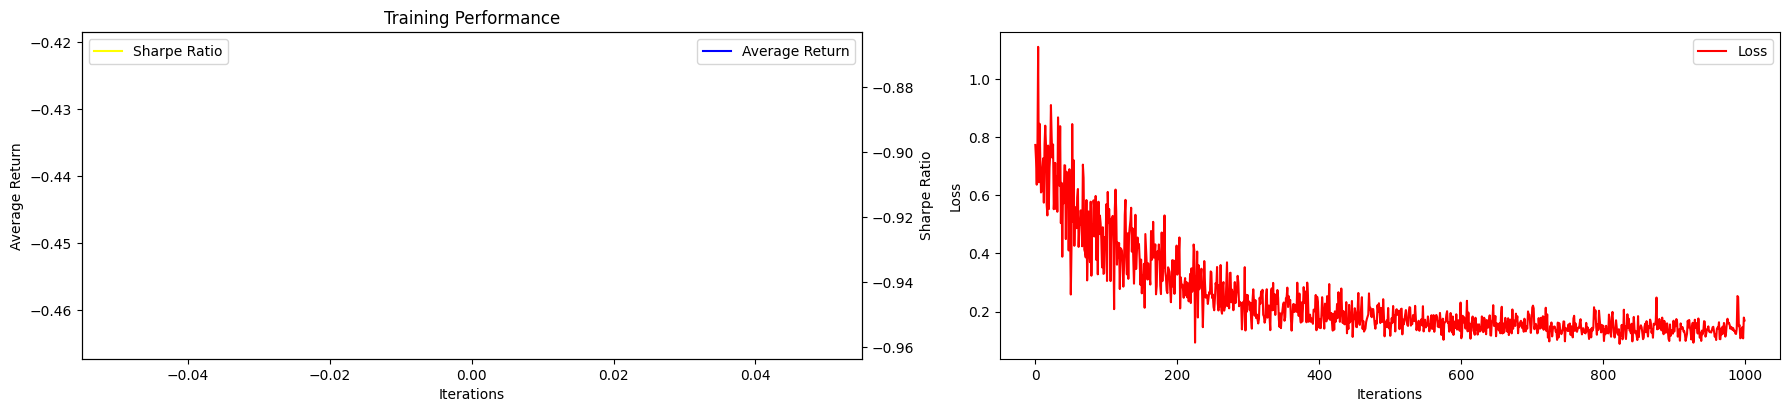

In [12]:
def train():
  with strategy.scope():
    loss = sim.train()
    sim.plot_performance(loss)
    sim.eval_metrics(25)
# Uncomment this for a new run to remove previously saved policies and checkpoints
sim.clear_directories()
train()

In [13]:
with strategy.scope():
    sim.load_and_eval_policy(policy_path=MODELS_PATH)

Average Return = -0.39498332142829895, Total Return = -1.0, Sharpe = -0.829620897769928


In [14]:
test_env.get_trade_stats()

{'Annualized Return': 0.22296088865895836,
 'Annualized Vol': 0.41661298262103946,
 'Sharpe Ratio': 0.418052264992189,
 'Downside Deviation': 0.3237132971680177,
 'Sortino Ratio': 0.0021350217327762338,
 'Max Drawdown': -0.3892130674385342,
 'Max Drawdown Days': 210,
 'Trade Churn': 0.0,
 'Skewness': -0.17075432371363236,
 'Kurtosis': 5.238606741020142}

# Metrics

Our baseine metrics are below:
```json
{'Annualized Return': 0.14078575066760193,
 'Annualized Vol': 0.49574842484791937,
 'Sharpe Ratio': 0.18555956692497932,
 'Downside Deviation': 0.37052224203081857,
 'Sortino Ratio': 0.000985212399707947,
 'Max Drawdown': -0.46389763370003145,
 'Max Drawdown Days': 394,
 'Trade Churn': 0.0,
 'Skewness': 0.035579521102068995,
 'Kurtosis': 5.3966430486047585}
```

Compared the the paper's benchmarks and their TQDM architecture, we did better with our Tensorflow setup and architecture (we took a guess at some hyper params), with the exception of the drawdown duration, Sharpe, and Sortino ratios:

| Metric                 | Article Baseline       | B&H               | S&H              | TF                | MR               | TDQN Benchmark   | 
|------------------------|------------------------|-------------------|------------------|-------------------|------------------|------------------|
| Annualized Return      | 14.08%                 | 24.11%            | -7.38%           | -100.00%          | 19.02%           | 12.80%           | 
| Annualized Vol         | 49.57%                 | 53.14%            | 46.11%           | 52.70%            | 58.05%           | 52.09%           | 
| Sharpe Ratio           | 0.186                  | 0.508             | -0.154           | -0.987            | 0.358            | 0.261            | 
| Sortino Ratio          | 0.0010                 | 0.741             | -0.205           | -1.229            | 0.539            | 0.359            | 
| Max Drawdown           | -46.39%                | 52.83%            | 54.09%           | 79.91%            | 65.31%           | 58.95%           | 
| Max Drawdown Days      | 394                    | 205               | 144              | 229               | 159              | 331              | 
| Trade Churn            | 0.00%                  | -                 | -                | -                 | -                | -                | 
| Skewness               | 0.036                  | -                 | -                | -                 | -                | -                | 
| Kurtosis               | 5.397                  | -                 | -                | -                 | -                | -                | 


Live episode started...


Steps executed: 471it [00:04, 107.88it/s]


...Live episode finished


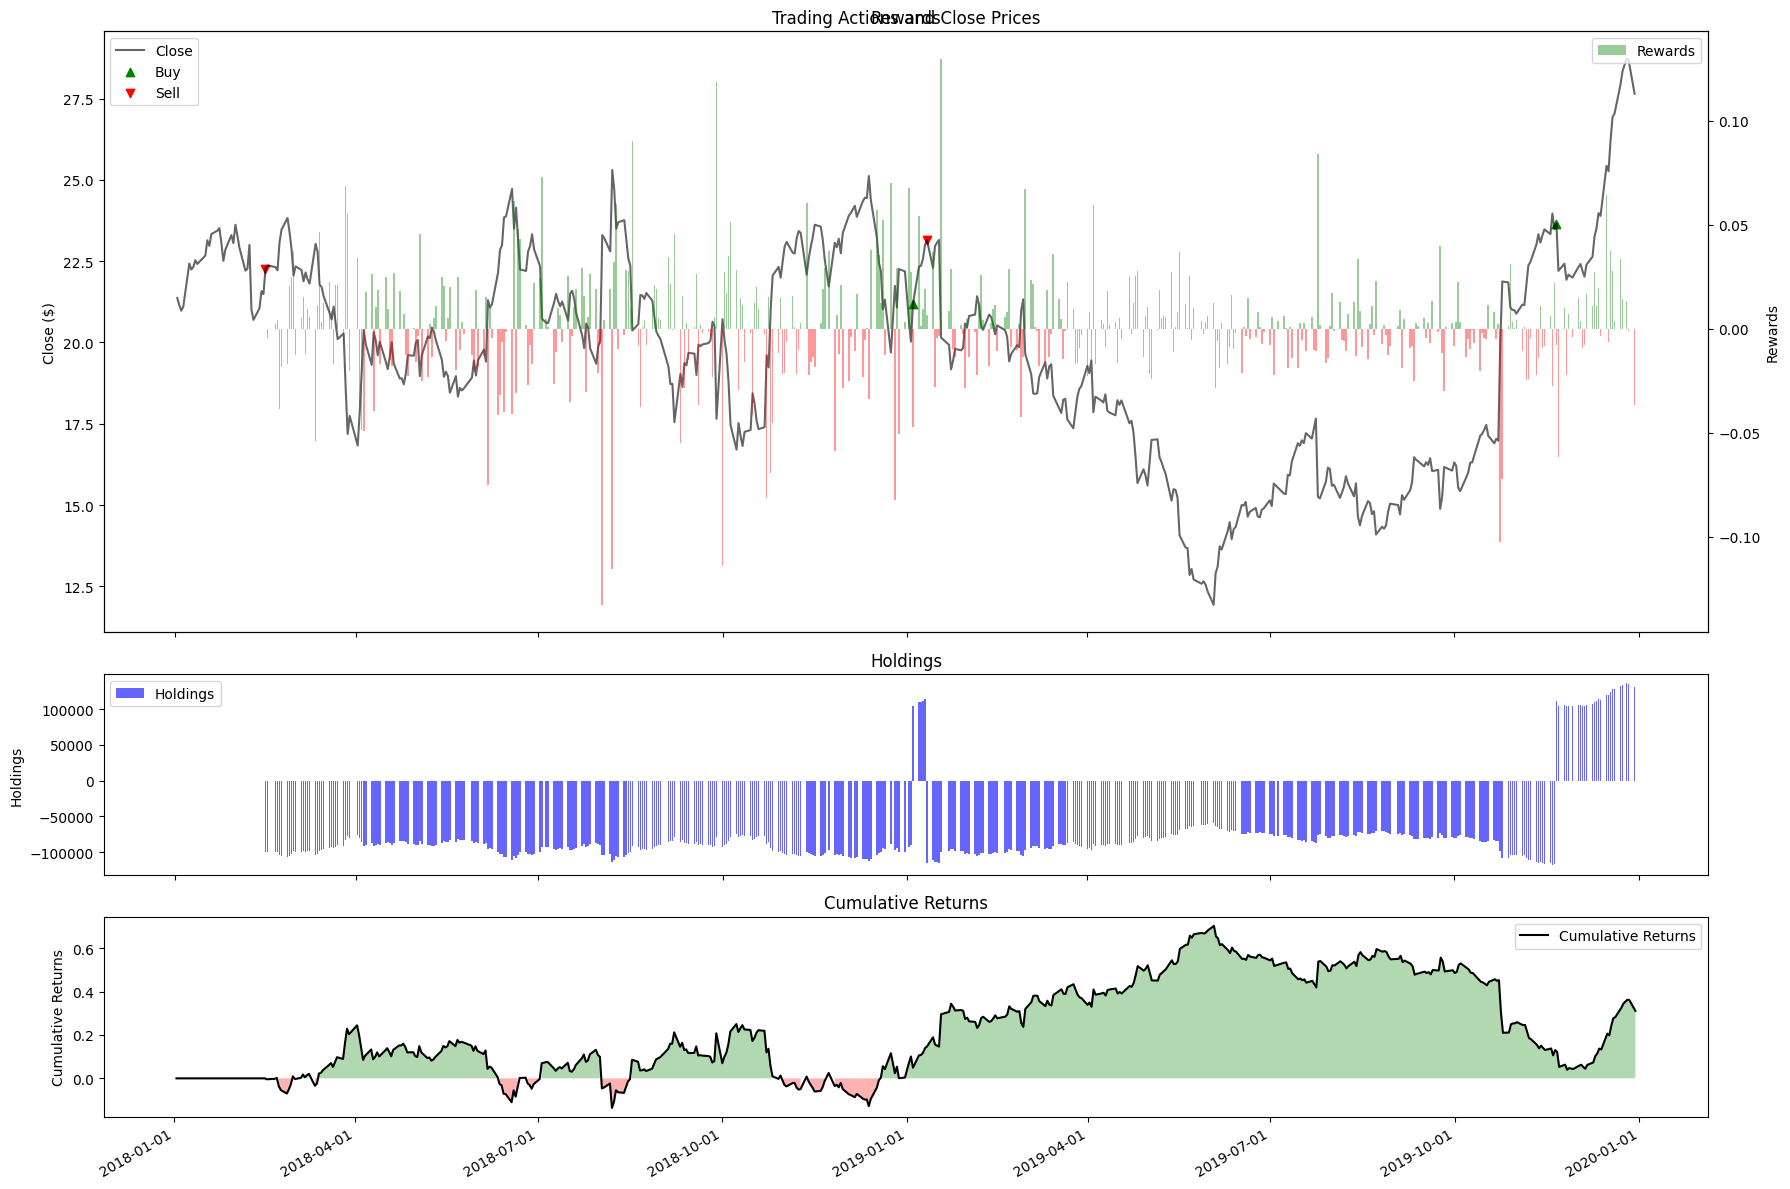

In [15]:
data = sim.plot_returns_and_actions()

In [16]:
data

,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_HIST,MACD_SIG,ATR,...,Sharpe,Position,Action,Holdings,Cash,Money,Returns,Reward,Cumulative_Returns,Rewards
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,0.515557,0.544705,0.537416,0.561813,21.368668,0.060499,-0.040477,-0.119077,0.078601,0.582232,...,0.0,0,2,0.000000,100000.00000,100000.000000,0.000000,0.000000,0.000000,0.000000
2018-01-03,0.551004,0.557334,0.555663,0.548796,21.150000,0.065928,-0.058835,-0.109949,0.051113,0.586834,...,0.0,0,2,0.000000,100000.00000,100000.000000,0.000000,0.000000,0.000000,0.000000
2018-01-04,0.518984,0.530387,0.516081,0.538358,20.974667,0.239888,-0.086535,-0.110118,0.023584,0.606203,...,0.0,0,2,0.000000,100000.00000,100000.000000,0.000000,0.000000,0.000000,0.000000
2018-01-05,0.533753,0.525118,0.541426,0.546136,21.105333,0.068163,-0.096827,-0.096328,-0.000498,0.587855,...,0.0,0,2,0.000000,100000.00000,100000.000000,0.000000,0.000000,0.000000,0.000000
2018-01-08,0.531312,0.604674,0.555462,0.624836,22.427334,0.237102,0.001672,0.001736,-0.000064,0.648342,...,0.0,0,2,0.000000,100000.00000,100000.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,0.908547,0.946507,0.934432,0.953487,27.948000,0.348062,1.430910,0.395042,1.035868,0.775349,...,0.0,1,2,132501.467783,17.56459,132519.032373,0.033601,0.033601,0.325190,0.033601
2019-12-24,0.934462,0.960423,0.945220,0.977418,28.350000,0.179229,1.562356,0.421191,1.141165,0.780824,...,0.0,1,2,134407.351809,17.56459,134424.916399,0.014382,0.014382,0.344249,0.014382
2019-12-26,0.972076,0.992640,1.000000,1.000000,28.729334,0.261938,1.677797,0.429305,1.248492,0.764242,...,0.0,1,2,136205.771914,17.56459,136223.336504,0.013379,0.013379,0.362233,0.013379


# Experiments

## Experiment 1 - Sharpe Ratio as the Reward

Since we want to reduce the portolio's volatility while attaining higher returns, we should test having a rolling window Sharpe ration as the reward function with the assumption that our agent can minimize its portfolio's volatility. In our case, we need to square root the number of past trading sessions (max 252, the trading days in a year) to give an annualized Sharpe as a reward, The results are promising, better than the baseline:

```json
{'Annualized Return': 0.2483099753903375,
 'Annualized Vol': 0.5315927401982844,
 'Sharpe Ratio': 0.3753156743014152,
 'Downside Deviation': 0.3649215721069904,
 'Sortino Ratio': 0.0021695799842264578,
 'Max Drawdown': -0.5284848329394528,
 'Max Drawdown Days': 493,
 'Trade Churn': 0.0,
 'Skewness': 0.547255666186771,
 'Kurtosis': 5.424081523143858}
```


## Experiment 2: Technical Analysis (TA) Signals

Using the Pandas-TA library, we augment our timeseries with the following signals:

- Moving Average Convergence Divergence (MACD) is useful to confirm the presence of a trend. In addition, it can spot divergences from price, which can signal potential reversals. The MACD is created with a 12 day fast moving average (MA), a 26 day slow moving average (MA), and the signal which is a 9 day exponential moving average (EMA) of their differences.

- Average true range (ATR) will signal the agent price swings and their magnitude, this would hint at the environment's volatility. It's built by decomposing a 14 day moving average of price extremes.

Results:

```json
{'Annualized Return': 0.08037565358057806,
 'Annualized Vol': 0.5327752235074609,
 'Sharpe Ratio': 0.05927596580709699,
 'Downside Deviation': 0.36637039877343286,
 'Sortino Ratio': 0.00034205956635066734,
 'Max Drawdown': 0.0,
 'Max Drawdown Days': 672,
 'Trade Churn': 0.0,
 'Skewness': 0.5699760228074306,
 'Kurtosis': 5.441197183719924}
```

## Experiment 3: Macro Signals


In this experiment, we will give the agent insight on its macro environment through the following timeseries:

- VIX - the volatility and fear index for the current period.
- 10 Year Treasury Note Yield - as a proxy to inflation.
- S&P 500 - For the market risk factor.

Gives these results:
```json
{'Annualized Return': 0.7375854975646395,
 'Annualized Vol': 0.48576500545216406,
 'Sharpe Ratio': 1.417950247927827,
 'Downside Deviation': 0.30906051769218884,
 'Sortino Ratio': 0.008843886276718567,
 'Max Drawdown': -0.38977234510237335,
 'Max Drawdown Days': 142,
 'Trade Churn': 0.0,
 'Skewness': 0.7135103541646352,
 'Kurtosis': 4.722124713372126}
```



# Side-by-Side Experiment Results

| Metric                 | Article Baseline       | Exp 1: Sharpe        | Exp 2: TA            | Exp 3: Macro         | B&H               | S&H              | TF                | MR               | TQDN Benchmark   | 
|------------------------|------------------------|----------------------|----------------------|----------------------|-------------------|------------------|-------------------|------------------|------------------|
| Annualized Return      | 14.08%                 | 24.83%               | 8.04%                | 73.76%               | 24.11%            | -7.38%           | -100.00%          | 19.02%           | 12.80%           | 
| Annualized Vol         | 49.57%                 | 53.16%               | 53.28%               | 48.58%               | 53.14%            | 46.11%           | 52.70%            | 58.05%           | 52.09%           | 
| Sharpe Ratio           | 0.186                  | 0.375                | 0.059                | 1.418                | 0.508             | -0.154           | -0.987            | 0.358            | 0.261            | 
| Sortino Ratio          | 0.001                  | 0.0022               | 0.0003               | 0.0088               | 0.741             | -0.205           | -1.229            | 0.539            | 0.359            | 
| Max Drawdown           | -46.39%                | -52.85%              | 0.00%                | -38.98%              | 52.83%            | 54.09%           | 79.91%            | 65.31%           | 58.95%           | 
| Max Drawdown Days      | 394                    | 493                  | 672                  | 142                  | 205               | 144              | 229               | 159              | 331              | 
| Trade Churn            | 0.00%                  | 0.00%                | 0.00%                | 0.00%                | -                 | -                | -                 | -                | -                | 
| Skewness               | 0.036                  | 0.547                | 0.570                | 0.714                | -                 | -                | -                 | -                | -                | 
| Kurtosis               | 5.397                  | 5.424                | 5.441                | 4.722                | -                 | -                | -                 | -                | -                | 


# Conclusion

In this article we have adapted Deep Q-Network (TDQN) algorithm from *Théate, Thibaut and Ernst, Damien (2021)*, using our signals and Tensorflow's Agent framework. Our agent can now determine optimal trading positions (buy, sell, or hold) to maximize our portfolio returns in a simulated environment.

## References

- [A Random Walk Down Wall Street](https://www.amazon.co.uk/Random-Walk-Down-Wall-Street/dp/0393330338)
- [TensorFlow Agents](https://www.tensorflow.org/agents/overview)
- [Open Gym AI Github](https://github.com/openai/gym)
- [Greg et al, OpenAI Gym, (2016)](https://arxiv.org/abs/1606.01540)
- [Théate, Thibaut, and Damien Ernst. "An application of deep reinforcement learning to algorithmic trading." Expert Systems with Applications 173 (2021): 114632.](https://www.sciencedirect.com/science/article/pii/S0957417421000737)
- [Remote development in WSL](https://code.visualstudio.com/docs/remote/wsl-tutorial)
- [NVIDIA Driver Downloads](https://www.nvidia.com/Download/index.aspx)
- [CUDA Toolkit](https://developer.nvidia.com/cuda-toolkit-archive)
- [TensorRT for CUDA](https://docs.nvidia.com/deeplearning/tensorrt/archives/index.html#trt_7)
- [Momentum and Reversion Trading Signals Analysis](https://medium.com/call-for-atlas/momentum-and-reversion-the-poor-mans-trading-strategies-9b8e1e6d3496)
- [Temporal Convolutional Neural Network with Conditioning for Broad Market Signals](https://medium.com/call-for-atlas/temporal-convolutional-neural-network-with-conditioning-for-broad-market-signals-9f0b0426b2b9)
- [Pandas TA - A Technical Analysis Library in Python 3](https://github.com/twopirllc/pandas-ta)

## Github

Article and code available on [Github](https://github.com/adamd1985/Deep-Q-Learning-Applied-to-Algorithmic-Trading)

Kaggle notebook available [here](https://www.kaggle.com/code/addarm/deep-q-rl-with-algorithmic-trading-policy)

Google Collab available [here](https://colab.research.google.com/github/adamd1985/Deep-Q-Learning-Applied-to-Algorithmic-Trading/blob/main/drl_trading.ipynb)

## Media

All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.